# SUPPA2 evaluation

- Author: Francisco M Martin Zamora
- Date: 8 to 10 Sep 2025

## 1. Objective

We want to evaluate and plot the results of the SUPPA2 data that was run on the `salmon` output.

## 2. Data preparation and loading

Load libraries of interest:

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob

from mplcursors import cursor

Set relevant directories and paths to the files of interest:

In [60]:
hackathon_dir = "/weka/projects/bioinf/Data/hackathon_splicing"
suppa_dir = hackathon_dir + "/suppa2"
output_dir = hackathon_dir + "/short_read_methods_comparison"

In [61]:
# Function to get all files matching a pattern
def get_files(pattern):
    return glob.glob(os.path.join(suppa_dir, pattern))

# Get PSI files
psi_files = {'H9': {}, 'K562': {}}
for file in get_files('salmon_*_*.psi'):
    filename = os.path.basename(file)
    parts = filename.replace('salmon_', '').replace('.psi', '').split('_')
    if len(parts) == 2:  # Ensure we have both cell line and event type
        cell_line, event_type = parts
        psi_files[cell_line][event_type] = file

# Get dPSI files
dpsi_files = {}
for file in get_files('salmon.differential_splicing_*.dpsi'):
    filename = os.path.basename(file)
    event_type = filename.replace('salmon.differential_splicing_', '').replace('.dpsi', '')
    dpsi_files[event_type] = file

# Get avglogtpm files
avglogtpm_files = {}
for file in get_files('salmon.differential_splicing_*_avglogtpm.tab'):
    filename = os.path.basename(file)
    event_type = filename.replace('salmon.differential_splicing_', '').replace('_avglogtpm.tab', '')
    avglogtpm_files[event_type] = file

In [62]:
print("---PSI files---")
for cell_line, events in psi_files.items():
    print(f"\n{cell_line}:")
    for event_type, path in sorted(events.items()):
        print(f"- {event_type}: {path}")

print("\n---DPSI files---")
for event_type, path in sorted(dpsi_files.items()):
    print(f"- {event_type}: {path}")

print("\n---AvgLogTPM files---")
for event_type, path in sorted(avglogtpm_files.items()):
    print(f"- {event_type}: {path}")

---PSI files---

H9:
- A3: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_A3.psi
- A5: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_A5.psi
- AF: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_AF.psi
- AL: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_AL.psi
- MX: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_MX.psi
- RI: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_RI.psi
- SE: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_SE.psi
- isoform: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_isoform.psi

K562:
- A3: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_A3.psi
- A5: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_A5.psi
- AF: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_AF.psi
- AL: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_AL.psi
- MX: /weka/projects/bioinf/Data/hackathon

Now we can load them:

In [63]:
# Define the order of event types
event_order = ['A3', 'A5', 'AF', 'AL', 'MX', 'RI', 'SE', 'isoform']

# Dictionaries to store the loaded dataframes
psi_dict = {'H9': {}, 'K562': {}}
dpsi_dict = {}
avglogtpm_dict = {}

# Load PSI files in order
for cell_line in ['H9', 'K562']:
    for event_type in event_order:
        if event_type in psi_files[cell_line]:
            psi_dict[cell_line][event_type] = pd.read_csv(psi_files[cell_line][event_type], sep='\t')

# Load dPSI files in order
for event_type in event_order:
    if event_type in dpsi_files:
        dpsi_dict[event_type] = pd.read_csv(dpsi_files[event_type], sep='\t')

# Load avglogtpm files in order
for event_type in event_order:
    if event_type in avglogtpm_files:
        df = pd.read_csv(avglogtpm_files[event_type], sep='\t', header=None, index_col=0)
        df.index.name = None
        df.rename(columns={1: "avglogtpm"}, inplace=True)
        avglogtpm_dict[event_type] = df

Let's load a transcript to gene correspondence file too:

In [64]:
tx2gene = pd.read_csv("/home/fmartinzamora/datasets/altos-lab-bioinf/CI/Fran/" + \
    "hackathon_splicing/illumina_processed/star_salmon/tx2gene.tsv", sep="\t")
tx2genename = tx2gene.set_index('transcript_id')['gene_name'].to_dict()
geneid2name = tx2gene.set_index('gene_id')['gene_name'].to_dict()

Let's check the shape of these files. For the case of the PSI and delta PSI files, these should have the same number of rows, as those are the actual events and isoforms:

In [65]:
print("---PSI files---")
for cell_line in psi_dict:
    print(f"\n{cell_line}:")
    for event_type, df in psi_dict[cell_line].items():
        print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} samples")

print("\n---dPSI files---")
for event_type, df in dpsi_dict.items():
    print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} columns")

---PSI files---

H9:
  A3: 23990 events, 2 samples
  A5: 21502 events, 2 samples
  AF: 128627 events, 2 samples
  AL: 44778 events, 2 samples
  MX: 10242 events, 2 samples
  RI: 10453 events, 2 samples
  SE: 56513 events, 2 samples
  isoform: 252301 events, 2 samples

K562:
  A3: 23990 events, 2 samples
  A5: 21502 events, 2 samples
  AF: 128627 events, 2 samples
  AL: 44778 events, 2 samples
  MX: 10242 events, 2 samples
  RI: 10453 events, 2 samples
  SE: 56513 events, 2 samples
  isoform: 252301 events, 2 samples

---dPSI files---
  A3: 23990 events, 2 columns
  A5: 21502 events, 2 columns
  AF: 128627 events, 2 columns
  AL: 44778 events, 2 columns
  MX: 10242 events, 2 columns
  RI: 10453 events, 2 columns
  SE: 56513 events, 2 columns
  isoform: 252296 events, 2 columns


In the case of the AvgLogTPM files, there should be less rows:

In [66]:
print("---AvgLogTPM files---")
for event_type, df in avglogtpm_dict.items():
    print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} columns")

---AvgLogTPM files---
  A3: 15110 events, 1 columns
  A5: 13259 events, 1 columns
  AF: 46759 events, 1 columns
  AL: 13191 events, 1 columns
  MX: 3477 events, 1 columns
  RI: 7597 events, 1 columns
  SE: 34098 events, 1 columns
  isoform: 166759 events, 1 columns


Let's visualise an example of each file type:

In [67]:
psi_dict['H9']['isoform'].head(10)

,SGNex_H9_Illumina_replicate2_run1,SGNex_H9_Illumina_replicate3_run1
ENSG00000160072;ENST00000673477,0.055639,0.058876
ENSG00000160072;ENST00000308647,0.369074,0.404611
ENSG00000160072;ENST00000472194,0.061047,0.063513
ENSG00000160072;ENST00000378736,0.424519,0.362744
ENSG00000160072;ENST00000485748,0.055994,0.073282
ENSG00000160072;ENST00000474481,0.033727,0.036974
ENSG00000279928;ENST00000624431,NaN,NaN
ENSG00000228037;ENST00000424215,NaN,NaN
ENSG00000142611;ENST00000511072,0.000000,0.000000
ENSG00000142611;ENST00000607632,0.575920,0.000000


In [68]:
dpsi_dict['isoform'].head(10)

,salmon_H9_isoform-salmon_K562_isoform_dPSI,salmon_H9_isoform-salmon_K562_isoform_p-val
ENSG00000000003;ENST00000373020,0.420224,0.067433
ENSG00000000003;ENST00000494424,0.000000,1.000000
ENSG00000000003;ENST00000496771,-0.075621,0.237263
ENSG00000000003;ENST00000612152,-0.002450,1.000000
ENSG00000000003;ENST00000614008,-0.342152,0.067433
ENSG00000000005;ENST00000373031,0.521730,0.027473
ENSG00000000005;ENST00000485971,-0.521730,0.027473
ENSG00000000419;ENST00000371582,0.069390,0.063936
ENSG00000000419;ENST00000371584,0.017048,1.000000
ENSG00000000419;ENST00000371588,-0.164718,0.000000


In [69]:
avglogtpm_dict['isoform'].head(10)

,avglogtpm
ENSG00000160072;ENST00000673477,1.710206
ENSG00000160072;ENST00000472194,1.710206
ENSG00000160072;ENST00000378736,1.710206
ENSG00000160072;ENST00000485748,1.710206
ENSG00000160072;ENST00000474481,1.710206
ENSG00000160072;ENST00000308647,1.710206
ENSG00000142611;ENST00000511072,-0.829460
ENSG00000142611;ENST00000607632,-0.829460
ENSG00000142611;ENST00000378391,-0.829460
ENSG00000142611;ENST00000514189,-0.829460


## 3. Differential splicing visualisation

### 3.1. Per isoform

In [70]:
common_index_isoform = dpsi_dict['isoform'].index.intersection(avglogtpm_dict['isoform'].index)
ma_plot_data_isoform = pd.DataFrame({
    'dpsi': dpsi_dict['isoform'].loc[common_index_isoform].iloc[:, 0],
    'avglogtpm': avglogtpm_dict['isoform'].loc[common_index_isoform].iloc[:, 0]
})
ma_plot_data_isoform.loc[:, 'gene_name'] = [geneid2name[i.split(';')[0]] for i in ma_plot_data_isoform.index]
ma_plot_data_isoform_above_threshold = ma_plot_data_isoform.loc[ma_plot_data_isoform['avglogtpm'] > 0]

volcano_plot_data_isoform = pd.DataFrame({
    'dpsi': dpsi_dict['isoform'].loc[common_index_isoform].iloc[:, 0],
    'pval': dpsi_dict['isoform'].loc[common_index_isoform].iloc[:, 1]
})
volcano_plot_data_isoform_above_threshold = volcano_plot_data_isoform.loc[ma_plot_data_isoform['avglogtpm'] > 0]
volcano_plot_data_isoform_above_threshold.loc[:, 'gene_name'] = [geneid2name[i.split(';')[0]] for i in volcano_plot_data_isoform_above_threshold.index]

/tmp/ipykernel_1724/2627352447.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



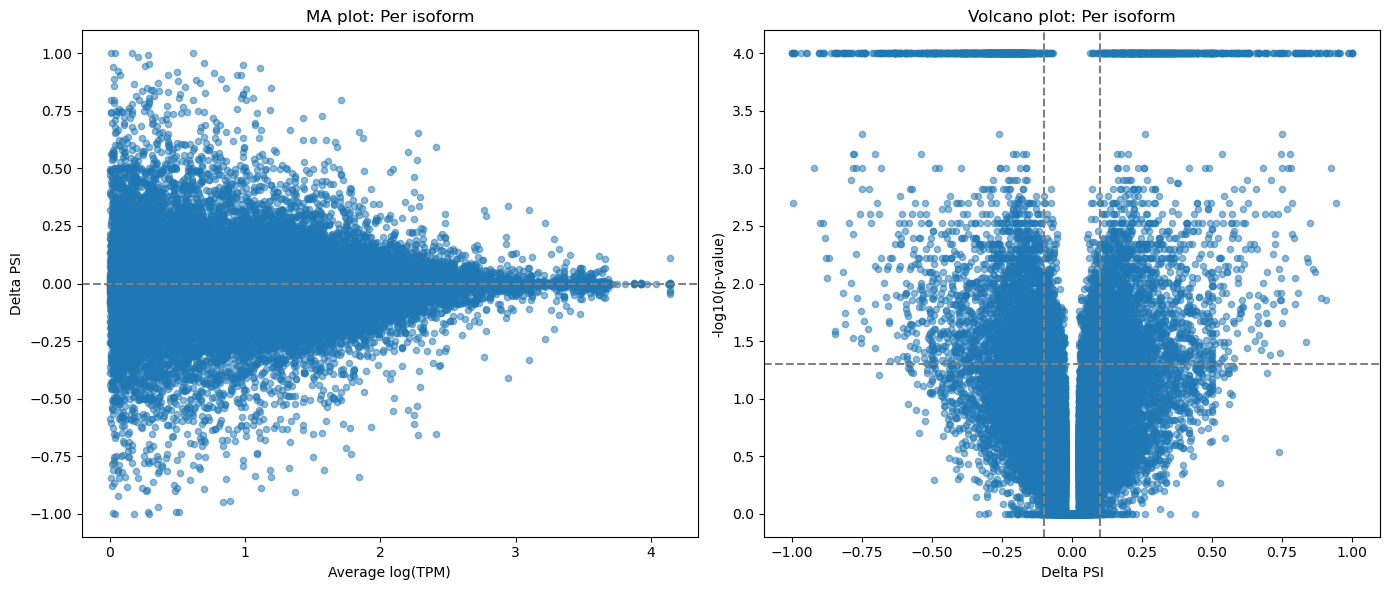

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# MA plot
axs[0].scatter(ma_plot_data_isoform_above_threshold['avglogtpm'], ma_plot_data_isoform_above_threshold['dpsi'], alpha=0.5, s=20)
axs[0].axhline(0, color='grey', linestyle='--')
axs[0].set_xlabel('Average log(TPM)')
axs[0].set_ylabel('Delta PSI')
axs[0].set_title('MA plot: Per isoform')

# Volcano plot
# Use volcano_plot_data_isoform for dpsi and pval
dpsi = volcano_plot_data_isoform_above_threshold['dpsi']
pvals = volcano_plot_data_isoform_above_threshold['pval']
neglog10p = -np.log10(np.clip(pvals, 1e-4, 1))
axs[1].scatter(dpsi, neglog10p, alpha=0.5, s=20)
axs[1].set_xlabel('Delta PSI')
axs[1].set_ylabel('-log10(p-value)')
axs[1].set_title('Volcano plot: Per isoform')
axs[1].axvline(-0.1, color='grey', linestyle='--')
axs[1].axvline(0.1, color='grey', linestyle='--')
axs[1].axhline(-np.log10(0.05), color='grey', linestyle='--')

plt.tight_layout()
plt.show()

In [72]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('MA plot: Per isoform', 'Volcano plot: Per isoform'),
                    horizontal_spacing=0.15)

# MA plot
fig.add_trace(
    go.Scatter(
        x=ma_plot_data_isoform_above_threshold['avglogtpm'],
        y=ma_plot_data_isoform_above_threshold['dpsi'],
        mode='markers',
        marker=dict(size=8, opacity=0.5),
        hovertemplate=
        'Gene: %{text}<br>' +
        'Average log(TPM): %{x:.2f}<br>' +
        'Delta PSI: %{y:.2f}<br>' +
        '<extra></extra>',
        text=ma_plot_data_isoform_above_threshold.index  # Using index as gene names
    ),
    row=1, col=1
)

# Add horizontal line at y=0 for MA plot
fig.add_shape(
    type="line", line=dict(dash="dash", color="grey"),
    x0=ma_plot_data_isoform_above_threshold['avglogtpm'].min(),
    x1=ma_plot_data_isoform_above_threshold['avglogtpm'].max(),
    y0=0, y1=0,
    row=1, col=1
)

# Volcano plot
dpsi = volcano_plot_data_isoform_above_threshold['dpsi']
pvals = volcano_plot_data_isoform_above_threshold['pval']
neglog10p = -np.log10(np.clip(pvals, 1e-4, 1))

fig.add_trace(
    go.Scatter(
        x=dpsi,
        y=neglog10p,
        mode='markers',
        marker=dict(size=8, opacity=0.5),
        hovertemplate=
        'Gene: %{text}<br>' +
        'Delta PSI: %{x:.2f}<br>' +
        '-log10(p-value): %{y:.2f}<br>' +
        '<extra></extra>',
        text=volcano_plot_data_isoform_above_threshold.index  # Using index as gene names
    ),
    row=1, col=2
)

# Add vertical lines at x=-0.1 and x=0.1 for Volcano plot
for x_val in [-0.1, 0.1]:
    fig.add_shape(
        type="line", line=dict(dash="dash", color="grey"),
        x0=x_val, x1=x_val,
        y0=min(neglog10p), y1=max(neglog10p),
        row=1, col=2
    )

# Add horizontal line at -log10(0.05) for Volcano plot
fig.add_shape(
    type="line", line=dict(dash="dash", color="grey"),
    x0=min(dpsi), x1=max(dpsi),
    y0=-np.log10(0.05), y1=-np.log10(0.05),
    row=1, col=2
)

# Update layout
fig.update_layout(
    width=1200,
    height=500,
    showlegend=False,
    template='plotly_white'
)

# Update x and y axis labels
fig.update_xaxes(title_text="Average log(TPM)", row=1, col=1)
fig.update_yaxes(title_text="Delta PSI", row=1, col=1)
fig.update_xaxes(title_text="Delta PSI", row=1, col=2)
fig.update_yaxes(title_text="-log10(p-value)", row=1, col=2)

# Save the figure to an HTML file
fig.write_html(suppa_dir + "/suppa2_salmon_isoform_interactive_plots.html")

# Print the location where the file was saved
import os
print("Interactive plot saved to:", os.path.abspath(suppa_dir + "/suppa2_salmon_isoform_interactive_plots.html"))

Interactive plot saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_isoform_interactive_plots.html


### 3.2. Per local alternative splicing (AS) events

In [73]:
# Get all keys except 'isoform'
keys_to_process = [key for key in dpsi_dict.keys() if key != 'isoform']

# Dictionary to store results
ma_plot_data = {}
ma_plot_data_above_threshold = {}
volcano_plot_data = {}
volcano_plot_data_above_threshold = {}


# Process each key
for key in keys_to_process:
    # Get common indices
    common_index = dpsi_dict[key].index.intersection(avglogtpm_dict[key].index)
    
    # Create MA plot data
    ma_plot_data[key] = pd.DataFrame({
        'dpsi': dpsi_dict[key].loc[common_index].iloc[:, 0],
        'avglogtpm': avglogtpm_dict[key].loc[common_index].iloc[:, 0]
    })
    ma_plot_data[key].loc[:, 'gene_name'] = [geneid2name[i.split(';')[0]] for i in ma_plot_data[key].index]
    ma_plot_data_above_threshold[key] = ma_plot_data[key].loc[ma_plot_data[key]['avglogtpm'] > 0]
    
    # Create volcano plot data
    volcano_plot_data[key] = pd.DataFrame({
        'dpsi': dpsi_dict[key].loc[common_index].iloc[:, 0],
        'pval': dpsi_dict[key].loc[common_index].iloc[:, 1]
    })
    
    # Filter for above threshold and add gene names
    volcano_plot_data_above_threshold[key] = volcano_plot_data[key].loc[ma_plot_data[key]['avglogtpm'] > 0]
    volcano_plot_data_above_threshold[key].loc[:, 'gene_name'] = [geneid2name[i.split(';')[0]] for i in volcano_plot_data_above_threshold[key].index]

/tmp/ipykernel_1724/2184287211.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1724/2184287211.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1724/2184287211.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

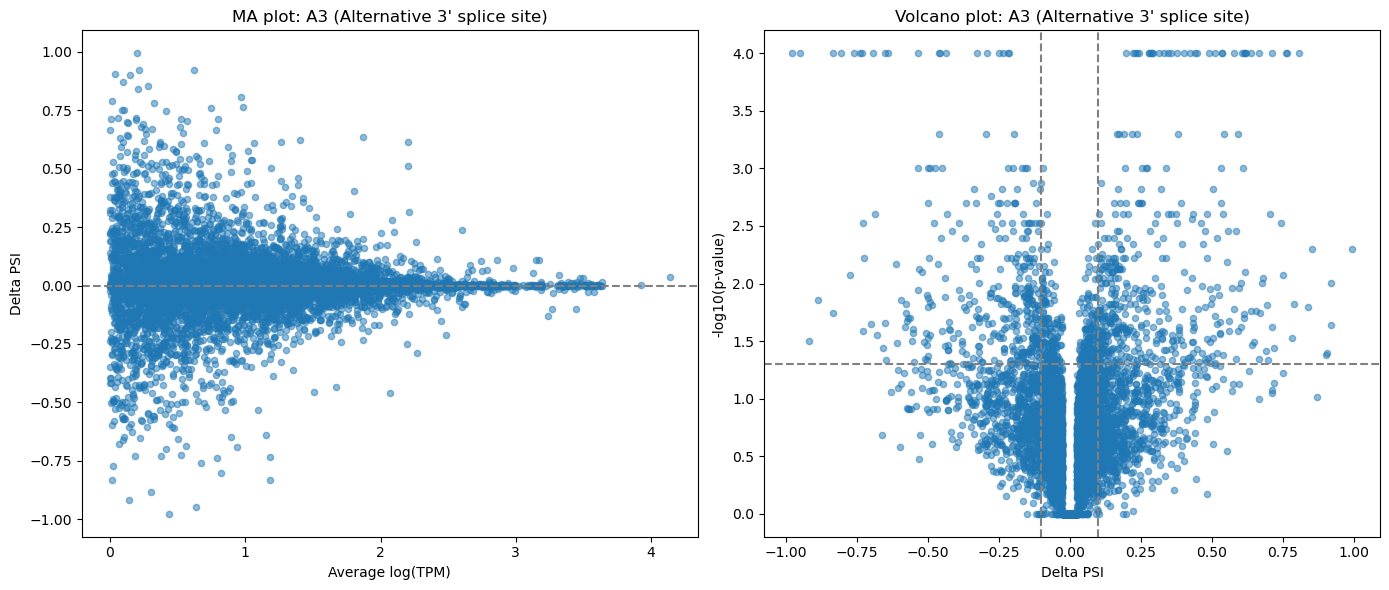

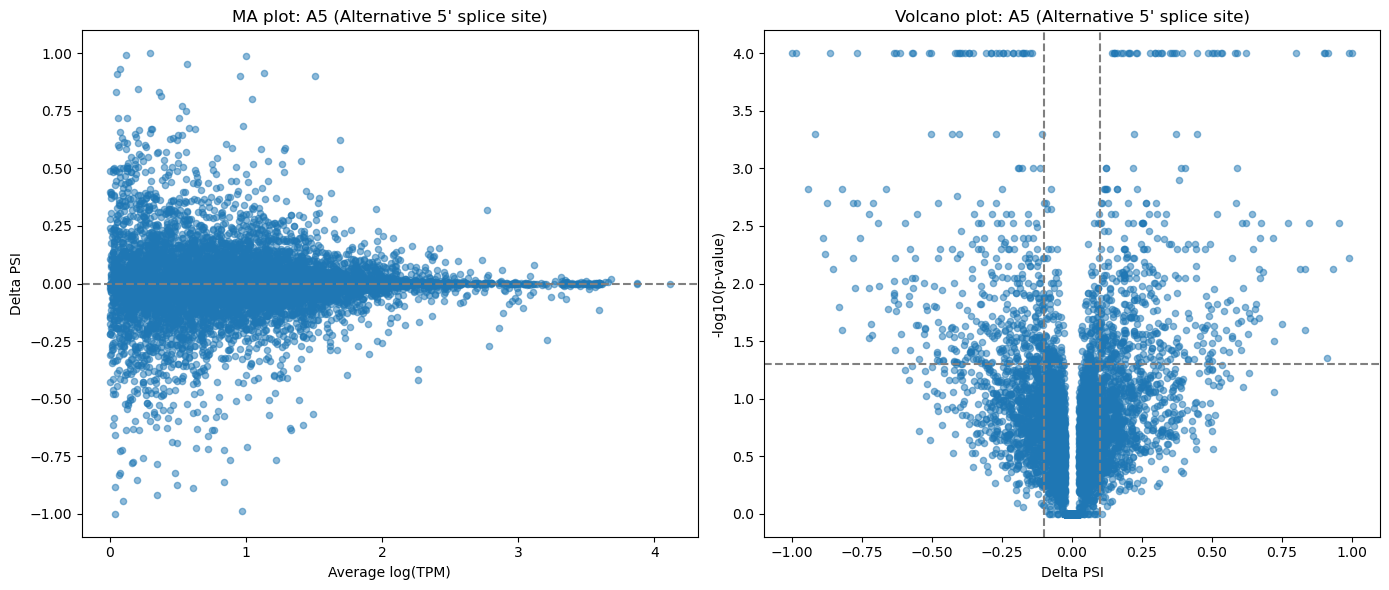

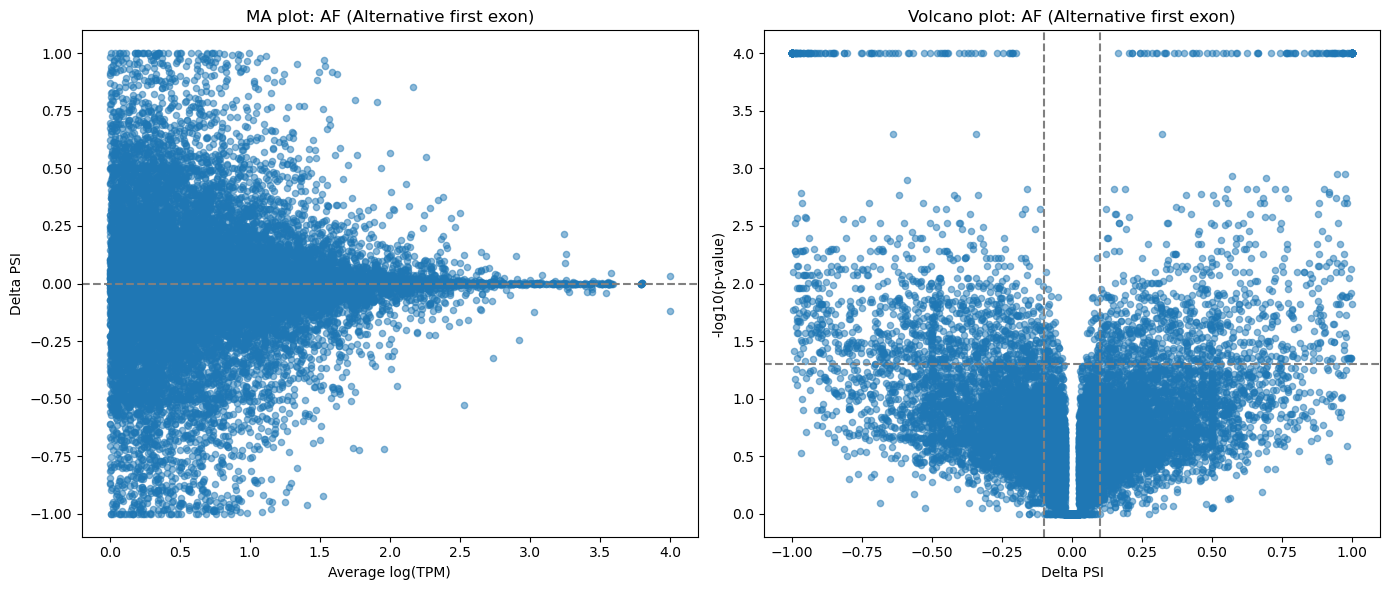

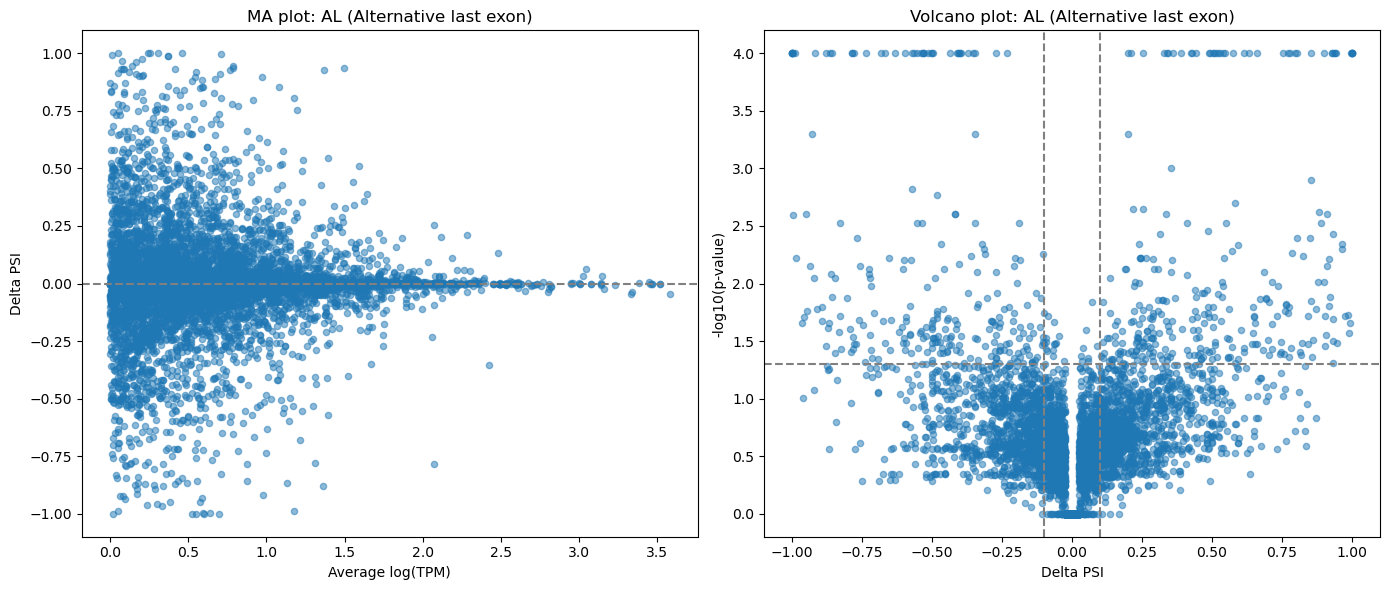

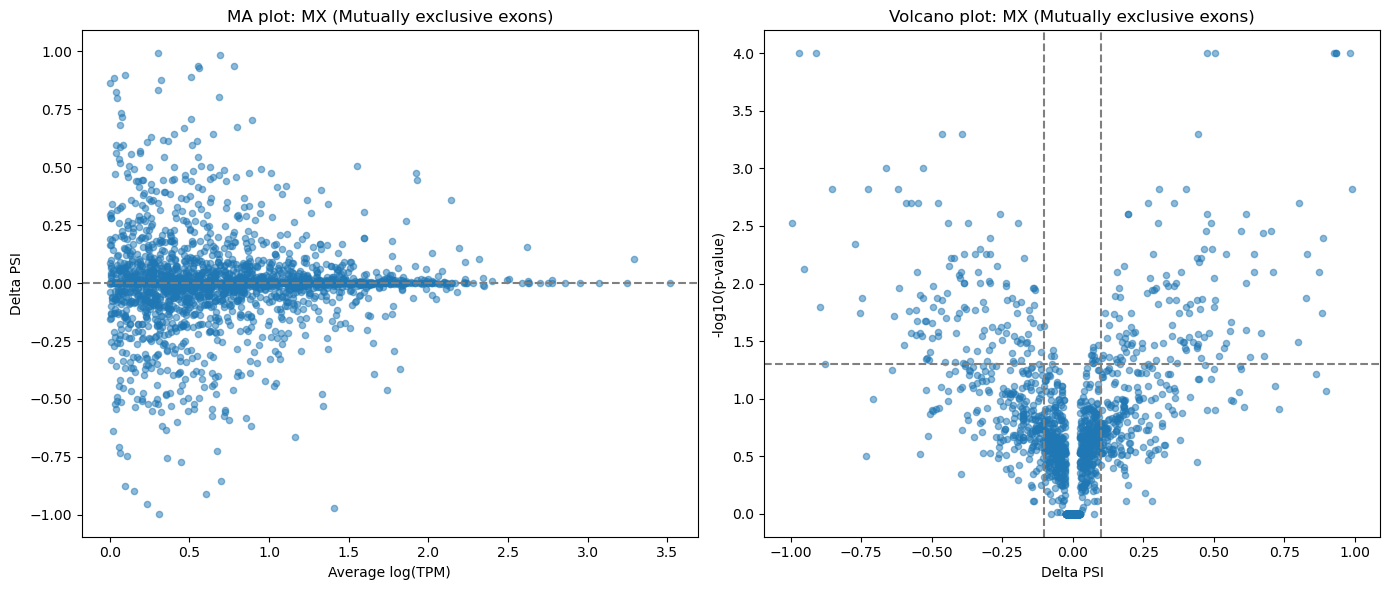

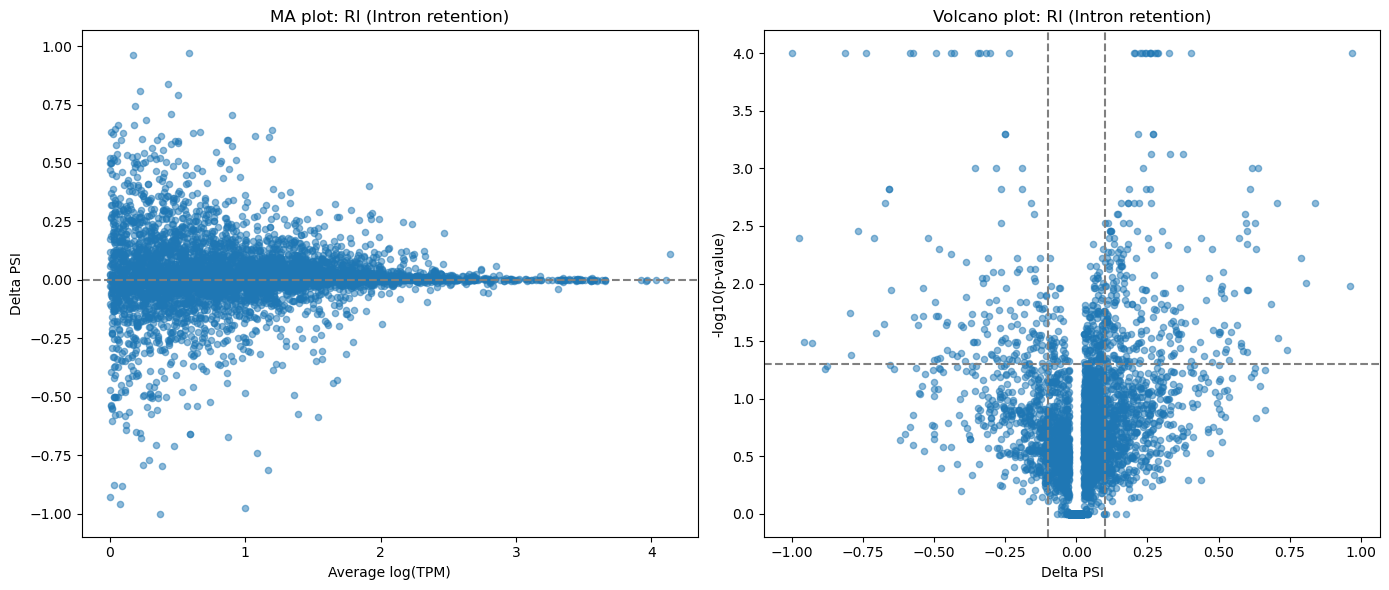

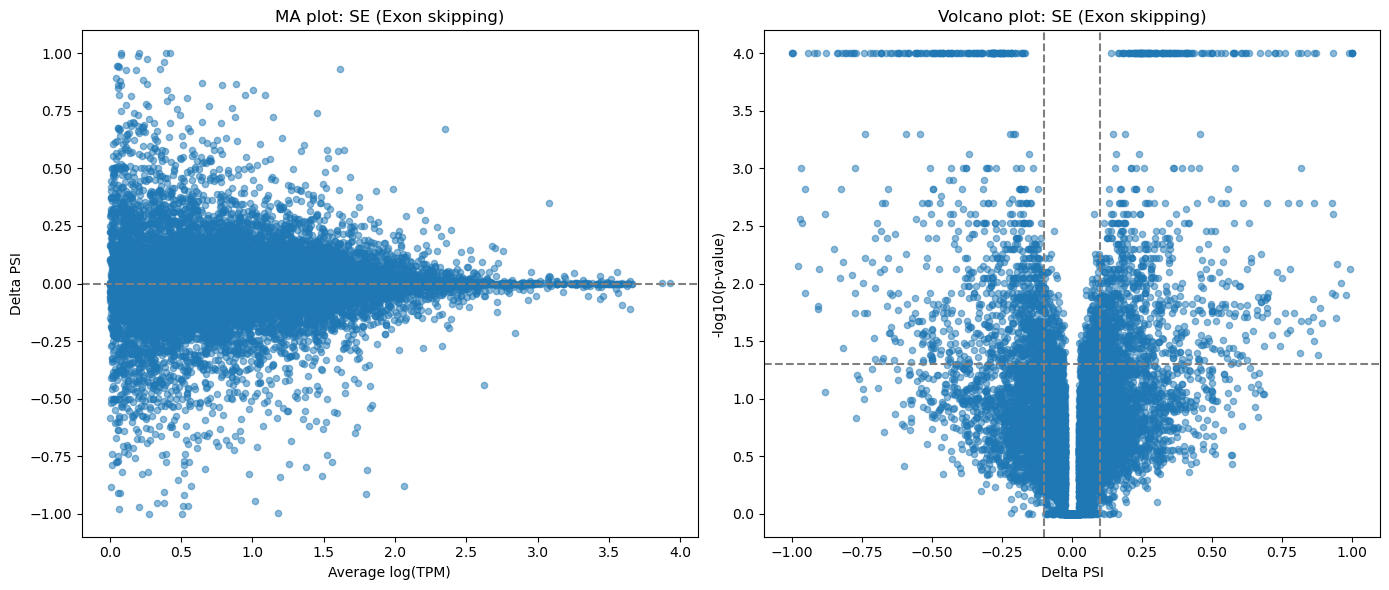

In [74]:
suppa_event_dictionary = {'A3': "Alternative 3' splice site",
                          'A5': "Alternative 5' splice site",
                          'AF': "Alternative first exon",
                          'AL': "Alternative last exon",
                          'MX': "Mutually exclusive exons",
                          'RI': "Intron retention",
                          'SE': "Exon skipping"}

for event_type in keys_to_process:
    # Create a new figure for each event type
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # MA plot
    axs[0].scatter(ma_plot_data_above_threshold[event_type]['avglogtpm'], 
                   ma_plot_data_above_threshold[event_type]['dpsi'], 
                   alpha=0.5, s=20)
    axs[0].axhline(0, color='grey', linestyle='--')
    axs[0].set_xlabel('Average log(TPM)')
    axs[0].set_ylabel('Delta PSI')
    axs[0].set_title(f'MA plot: {event_type} ({suppa_event_dictionary[event_type]})')
    
    # Volcano plot
    dpsi = volcano_plot_data_above_threshold[event_type]['dpsi']
    pvals = volcano_plot_data_above_threshold[event_type]['pval']
    neglog10p = -np.log10(np.clip(pvals, 1e-4, 1))
    
    axs[1].scatter(dpsi, neglog10p, alpha=0.5, s=20)
    axs[1].set_xlabel('Delta PSI')
    axs[1].set_ylabel('-log10(p-value)')
    axs[1].set_title(f'Volcano plot: {event_type} ({suppa_event_dictionary[event_type]})')
    axs[1].axvline(-0.1, color='grey', linestyle='--')
    axs[1].axvline(0.1, color='grey', linestyle='--')
    axs[1].axhline(-np.log10(0.05), color='grey', linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [75]:
for event_type in keys_to_process:
    # Create subplots
    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=(f'MA plot: {event_type}', f'Volcano plot: {event_type}'),
                        horizontal_spacing=0.15)

    # MA plot
    fig.add_trace(
        go.Scatter(
            x=ma_plot_data_above_threshold[event_type]['avglogtpm'],
            y=ma_plot_data_above_threshold[event_type]['dpsi'],
            mode='markers',
            marker=dict(size=8, opacity=0.5),
            hovertemplate=
            'Gene: %{text}<br>' +
            'Average log(TPM): %{x:.2f}<br>' +
            'Delta PSI: %{y:.2f}<br>' +
            '<extra></extra>',
            text=ma_plot_data_above_threshold[event_type].index  # Using index as gene names
        ),
        row=1, col=1
    )

    # Add horizontal line at y=0 for MA plot
    fig.add_shape(
        type="line", line=dict(dash="dash", color="grey"),
        x0=ma_plot_data_above_threshold[event_type]['avglogtpm'].min(),
        x1=ma_plot_data_above_threshold[event_type]['avglogtpm'].max(),
        y0=0, y1=0,
        row=1, col=1
    )

    # Volcano plot
    dpsi = volcano_plot_data_above_threshold[event_type]['dpsi']
    pvals = volcano_plot_data_above_threshold[event_type]['pval']
    neglog10p = -np.log10(np.clip(pvals, 1e-4, 1))

    fig.add_trace(
        go.Scatter(
            x=dpsi,
            y=neglog10p,
            mode='markers',
            marker=dict(size=8, opacity=0.5),
            hovertemplate=
            'Gene: %{text}<br>' +
            'Delta PSI: %{x:.2f}<br>' +
            '-log10(p-value): %{y:.2f}<br>' +
            '<extra></extra>',
            text=volcano_plot_data_above_threshold[event_type].index  # Using index as gene names
        ),
        row=1, col=2
    )

    # Add vertical lines at x=-0.1 and x=0.1 for Volcano plot
    for x_val in [-0.1, 0.1]:
        fig.add_shape(
            type="line", line=dict(dash="dash", color="grey"),
            x0=x_val, x1=x_val,
            y0=min(neglog10p), y1=max(neglog10p),
            row=1, col=2
        )

    # Add horizontal line at -log10(0.05) for Volcano plot
    fig.add_shape(
        type="line", line=dict(dash="dash", color="grey"),
        x0=min(dpsi), x1=max(dpsi),
        y0=-np.log10(0.05), y1=-np.log10(0.05),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        width=1200,
        height=500,
        showlegend=False,
        template='plotly_white'
    )

    # Update x and y axis labels
    fig.update_xaxes(title_text="Average log(TPM)", row=1, col=1)
    fig.update_yaxes(title_text="Delta PSI", row=1, col=1)
    fig.update_xaxes(title_text="Delta PSI", row=1, col=2)
    fig.update_yaxes(title_text="-log10(p-value)", row=1, col=2)

    # Save the figure to an HTML file
    output_file = f"{suppa_dir}/suppa2_salmon_{event_type}_interactive_plots.html"
    fig.write_html(output_file)

    # Print the location where the file was saved
    print(f"Interactive plot for {event_type} saved to:", os.path.abspath(output_file))

Interactive plot for A3 saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_A3_interactive_plots.html
Interactive plot for A5 saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_A5_interactive_plots.html
Interactive plot for AF saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_AF_interactive_plots.html
Interactive plot for AL saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_AL_interactive_plots.html
Interactive plot for MX saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_MX_interactive_plots.html
Interactive plot for RI saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_RI_interactive_plots.html
Interactive plot for SE saved to: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/suppa2_salmon_SE_interactive_plots.html
